In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../../code/')

import seaborn as sns
import reframed
import scipy.stats as st
from scipy.stats import linregress
import leakage
sns.set_theme(font_scale = 1, style = 'ticks')


# Description
The goal of this notebook is to see how much variability that is explained with different models used to predict the metabolite values

In [2]:
conditions = [
    ('Glucose', 'E. coli'),
    ('Galactose', 'E. coli'),
    ('L-alanine', 'E. coli'),
    ('L-malate', 'E. coli')
]
uptake_rates = {
    ('Glucose', 'E. coli'): -7.04,
    ('Galactose', 'E. coli'): -4.3,
    ('L-alanine', 'E. coli'): -17.25,
    ('L-malate', 'E. coli'): -16.5
}
model_folder = Path('../../../models/e_coli/')
model_fns = {
    'eciJO1366': model_folder / 'momentiJO1366_modified.xml',
    'iJO1366': model_folder / 'iJO1366.xml',
    'iAF1260': model_folder / 'iAF1260.xml',
    'iML1515': model_folder / 'iML1515.xml',
    'iJR904': model_folder / 'iJR904.xml',
}

cs_to_exchange = {
        'Galactose': 'R_EX_gal_e',
        'L-malate': 'R_EX_mal__L_e',
        'L-alanine': 'R_EX_ala__L_e',
        'Glucose': 'R_EX_glc__D_e'}

In [3]:
git_folder = Path('../../../')
fn = git_folder / 'data' / 'other'/'A_rates_and_values.csv'
df_rates = pd.read_csv(fn, index_col=0)
df_rates = df_rates.loc[~df_rates['Rate [mmol/gDW/h]'].isna()]

# Read in models

In [4]:
models = {}
for model_name, model_fn in model_fns.items():
    print(f'Processing {model_name}')
    model = reframed.load_cbmodel(model_fn)
    models[model_name] = model
    model.solver = 'gurobi'
    print(reframed.FBA(model, constraints={'R_EX_glc__D_e': -10}))


Processing eciJO1366
Set parameter Username
Set parameter LicenseID to value 2586336
Academic license - for non-commercial use only - expires 2025-11-18
Objective: 0.7044734318697953
Status: Optimal

Processing iJO1366
Objective: 0.9823718127269787
Status: Optimal

Processing iAF1260
Objective: 0.8855712275999393
Status: Optimal

Processing iML1515
Objective: 0.8769972144269733
Status: Optimal

Processing iJR904
Objective: 0.921948095050471
Status: Optimal



In [5]:
df_rates['Carbon source'].unique()

array(['Glucose', 'Galactose', 'L-malate', 'L-alanine', 'D-Glucose',
       'L-Malate', 'D-Fructose', 'D-Galactose', 'D-Ribose', 'L-Arabinose',
       'Glycerol', 'Pyruvate', 'Succinate', 'Fumarate', 'Acetate'],
      dtype=object)

In [6]:
df_rates = df_rates.loc[df_rates.Species == 'E. coli']


In [7]:
df_rates['Metabolite id']

15         2pg
33         3pg
42          ac
43          ac
44          ac
        ...   
768        ura
806     val__L
808     val__L
809     val__L
824    xu5p__D
Name: Metabolite id, Length: 133, dtype: object

In [8]:
shadow_prices = {}
for model_name, model in models.items():
    model_metabolites = [model.metabolites[m].id for m in model.metabolites]
    for condition, _ in conditions:
        metabolites = df_rates.loc[df_rates['Carbon source']== condition, 'Metabolite id'].values
        metabolite_ids = [f'M_{m_id}_c' for m_id in metabolites  if isinstance(m_id, str)]
        metabolite_ids = [m_id for m_id in metabolite_ids if m_id in model_metabolites]
        print(f'Processing {model_name}, {condition}')
        exchange_id = cs_to_exchange[condition]
        uptake_rate = uptake_rates[(condition, 'E. coli')]
        shadow_prices[(model_name, condition)] = leakage.estimate_shadow_prices_reframed(model, constraints={exchange_id: (uptake_rate,0)}, metabolites = metabolite_ids)
    

Processing eciJO1366, Glucose
Processing eciJO1366, Galactose
Processing eciJO1366, L-alanine
Processing eciJO1366, L-malate
Processing iJO1366, Glucose
Processing iJO1366, Galactose
Processing iJO1366, L-alanine
Processing iJO1366, L-malate
Processing iAF1260, Glucose
Processing iAF1260, Galactose
Processing iAF1260, L-alanine
Processing iAF1260, L-malate
Processing iML1515, Glucose
Processing iML1515, Galactose
Processing iML1515, L-alanine
Processing iML1515, L-malate
Processing iJR904, Glucose
Processing iJR904, Galactose
Processing iJR904, L-alanine
Processing iJR904, L-malate


In [9]:
# Convert the nested dict to a DataFrame
df_shadow = pd.DataFrame.from_dict(shadow_prices, orient='index').reset_index()
df_shadow = df_shadow.rename(columns={'level_0': 'Model', 'level_1': 'Condition'})

# Melt to long format
df_long = df_shadow.melt(id_vars=['Model', 'Condition'], var_name='Metabolite abbrv.', value_name='Shadow price')


In [10]:
df_long['log10(Met. value)'] = np.log10(-df_long['Shadow price'])
df_long['log10(Met. value)'] = df_long['log10(Met. value)'].replace([np.inf, -np.inf], np.nan)

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# First, extract the metabolite id from df_long['Metabolite']
df_long['Metabolite id'] = df_long['Metabolite abbrv.'].str.replace('^M_|_c$', '', regex=True)

# Now merge on 'Metabolite id' and 'Condition' (df_long) <-> 'Metabolite id' and 'Carbon source' (df_rates)
df_long = df_long.merge(
    df_rates[['Metabolite id', 'Carbon source', 'Rate [mmol/gDW/h]', 'Metabolite', 'log10(Rate [mmol/gDW/h])']],
    left_on=['Metabolite id', 'Condition'],
    right_on=['Metabolite id', 'Carbon source'],
    how='left'
)

In [12]:
print(df_long.loc[df_long['Shadow price'] >0])

       Model Condition Metabolite abbrv.  Shadow price  log10(Met. value)  \
833  iAF1260  L-malate           M_for_c  2.664535e-13                NaN   

    Metabolite id Carbon source  Rate [mmol/gDW/h] Metabolite  \
833           for      L-malate           0.077218    Formate   

     log10(Rate [mmol/gDW/h])  
833                 -1.112279  


In [13]:
df_long.dropna(subset= ['log10(Met. value)', 'log10(Rate [mmol/gDW/h])'], inplace=True)

In [14]:
print(df_long.loc[df_long['log10(Met. value)'] < -5])

      Model  Condition Metabolite abbrv.  Shadow price  log10(Met. value)  \
837  iJR904  Galactose           M_for_c -2.442491e-13         -12.612167   
839  iJR904   L-malate           M_for_c -2.220446e-14         -13.653560   

    Metabolite id Carbon source  Rate [mmol/gDW/h] Metabolite  \
837           for     Galactose           0.357255    Formate   
839           for      L-malate           0.077218    Formate   

     log10(Rate [mmol/gDW/h])  
837                 -0.447022  
839                 -1.112279  


In [15]:
# Drop metabolite values < 1e-5
print(len(df_long))
df_long = df_long[df_long['log10(Met. value)'] > -5]
print(len(df_long))

462
460


In [16]:
fit_data = []
for model_name, _ in models.items():
    for condition, _ in conditions:
        dfi = df_long[(df_long['Model'] == model_name) & (df_long['Condition'] == condition)].copy()
        dfi.dropna(subset=['log10(Met. value)', 'log10(Rate [mmol/gDW/h])'], inplace=True)
        logx = dfi['log10(Met. value)']
        logy = dfi['log10(Rate [mmol/gDW/h])']
        slope, intercept, rvalue, pvalue, _ = linregress(logx,logy)
        pearson_r, pearson_p = st.pearsonr(logx, logy)
        fit_data.append({
            'Model': model_name,
            'Condition': condition,
            'slope': slope,
            'intercept': intercept,
            'rvalue': rvalue,
            'pvalue': pvalue,
            'pearson_r': pearson_r,
            'pearson_p': pearson_p
        })
fit_df = pd.DataFrame(fit_data)


In [17]:
# 1. Add a rank/order column for the momentiJO1366 model
df_long['Order'] = np.nan
for condition in df_long['Condition'].unique():
    mask = (df_long['Model'] == 'eciJO1366') & (df_long['Condition'] == condition)
    met_to_order = df_long[mask].set_index('Metabolite').groupby(['Condition'])['log10(Met. value)'].rank(method='first')
    condition_mask = df_long['Condition'] == condition
    df_long.loc[condition_mask, 'Order'] = df_long.loc[condition_mask, 'Metabolite'].map(met_to_order)


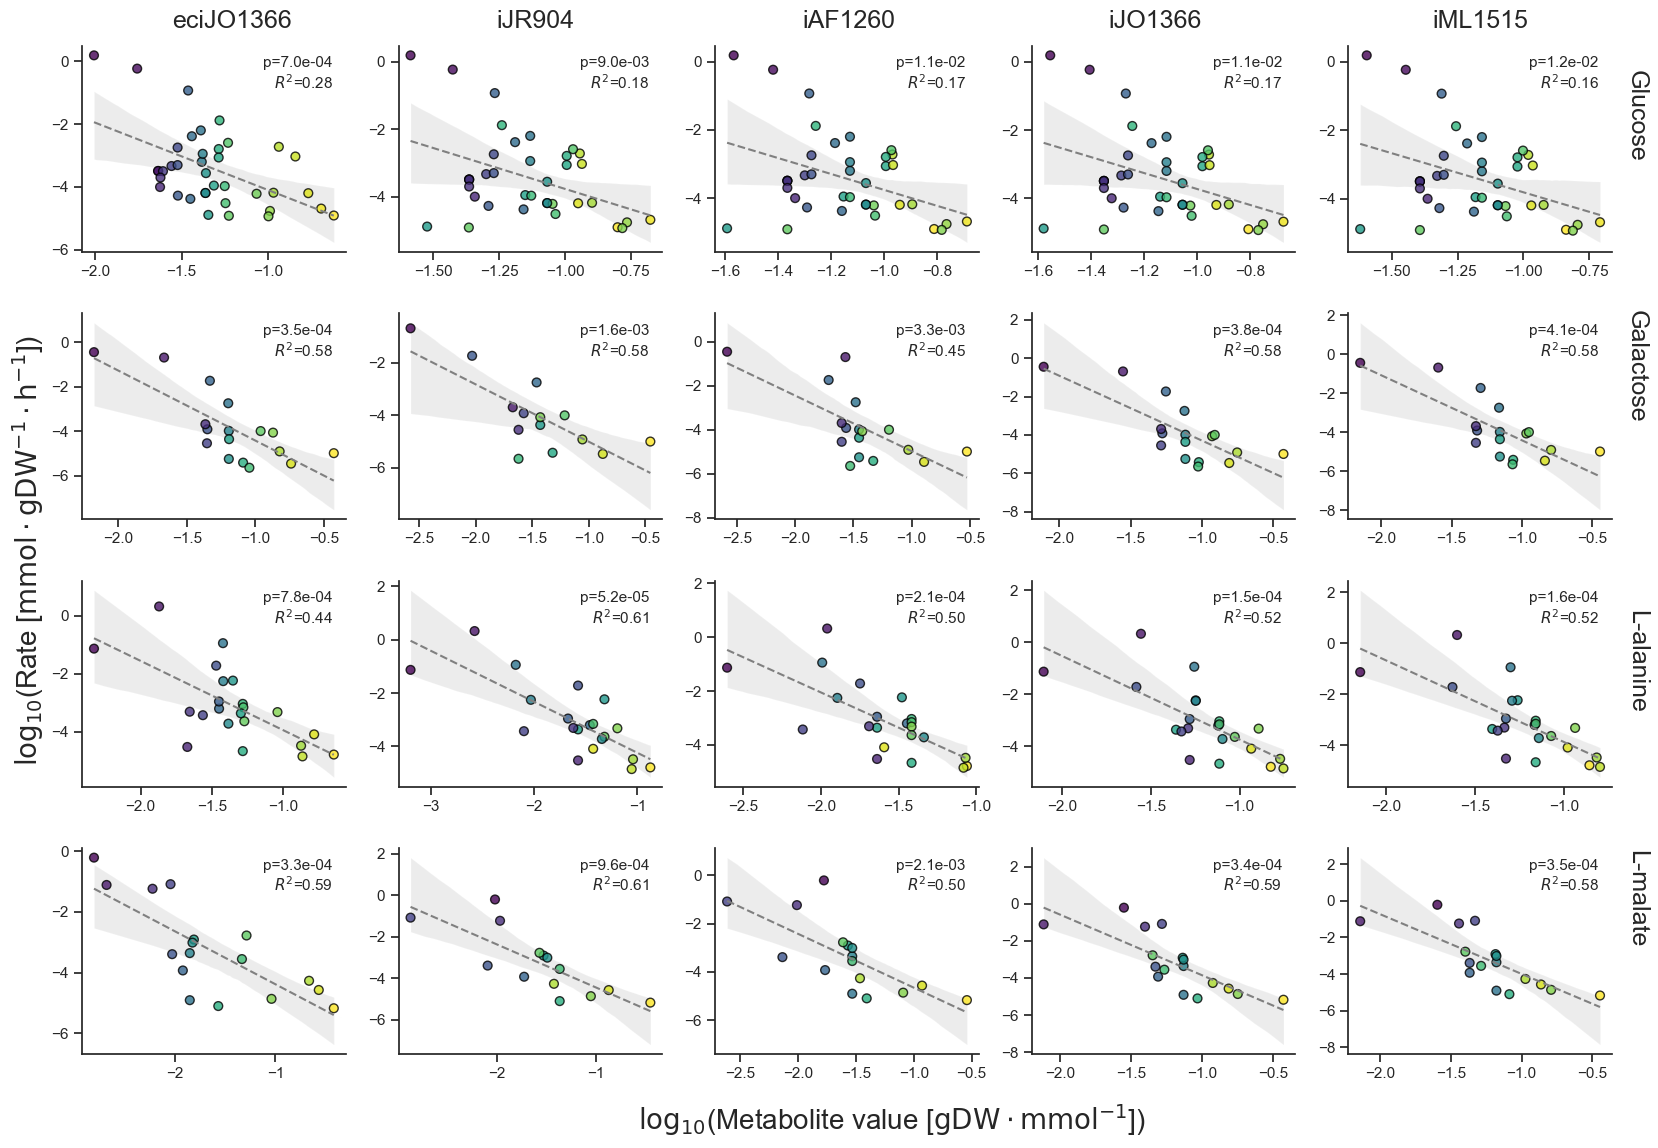

In [18]:
model_order = ['eciJO1366', 'iJR904', 'iAF1260','iJO1366','iML1515']
g = sns.lmplot(
    data=df_long,
    x='log10(Met. value)', y='log10(Rate [mmol/gDW/h])',
    col='Model', row='Condition', 
    # hue = 'Order',
    facet_kws={'sharex': False, 'sharey': False},
    height=3, aspect=1.2,
    col_order=model_order,
    scatter=False,
    line_kws={'color': 'grey', 'ls': '--', 'lw': 1.5},
)
# Use scatterplot with hue='order' and a continuous palette
for i, col_axes in enumerate(g.axes):
    for j, ax in enumerate(col_axes):
        model_name = g.col_names[j]
        condition = g.row_names[i]
        condition_df = df_long[(df_long['Model'] == model_name) & (df_long['Condition'] == condition)]
        if not condition_df.empty:
            sns.scatterplot(
                data=condition_df, x='log10(Met. value)', y='log10(Rate [mmol/gDW/h])',
                hue='Order', palette='viridis', ax=ax, legend=False, s=40, alpha=0.8, edgecolor='black', linewidth=1
            )

            
g.set_titles("")
g.set_axis_labels('','')
fig = g.fig
fig.supylabel(r'$\rm{log}_{10}$(Rate [$\rm{mmol \cdot gDW^{-1} \cdot h^{-1}}$])', x = 0.01, size = 20)

fig.supxlabel(r'$\rm{log}_{10}$(Metabolite value [$\rm{gDW \cdot mmol^{-1}}$])', y = 0.01, size = 20)
sns.despine()


# After plotting with lmplot
for ax in g.axes.flat:
    # Get current row and col values for this subplot
    row_val = ax.get_subplotspec().rowspan.start
    col_val = ax.get_subplotspec().colspan.start
    # Get the corresponding row/col names
    row_name = g.row_names[row_val]
    col_name = g.col_names[col_val]
    # Find the fit result for this subplot
    fit = fit_df[(fit_df['Model'] == col_name) & (fit_df['Condition'] == row_name)]
    if not fit.empty:
        rho = fit['pearson_r'].values[0]
        pval = fit['pearson_p'].values[0]
        ax.text(
            0.95, 0.95,
            f"p={pval:.1e}\n$R^2$={fit['rvalue'].values[0]**2:.2f}",#$\\rho$={rho:.2f}\n
            transform=ax.transAxes,
            ha='right', va='top', fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

title_size = 18
plt.text(0.1, 0.95, g.col_names[0], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.28, 0.95, g.col_names[1], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.45, 0.95, g.col_names[2], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.62, 0.95, g.col_names[3], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.8, 0.95, g.col_names[4], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)

plt.text(0.92, 0.9, g.row_names[0], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)
plt.text(0.92, 0.7, g.row_names[1], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)
plt.text(0.92, 0.45, g.row_names[2], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)
plt.text(0.92, 0.25, g.row_names[3], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)

plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.2, left=0.05, right=0.9, bottom=0.08)
plt.savefig(git_folder / 'figures' / 'all_ecoli_models_rates_vs_metabolite_values.pdf', bbox_inches='tight')
plt.savefig(git_folder / 'figures' / 'all_ecoli_models_rates_vs_metabolite_values.png', bbox_inches='tight', dpi=300)



In [19]:
corr_data = []
for model_name1, _ in models.items():
    for model_name2, _ in models.items():
        if model_name1 == model_name2:
            corr_data.append({
            'Model 1': model_name1,
            'Model 2': model_name2,
            'Pearson r': 1,
            'p-value': np.nan
        })
            continue
        df1 = df_long[df_long['Model'] == model_name1]
        df2 = df_long[df_long['Model'] == model_name2]
        merged_df = df1.merge(df2, on=['Metabolite abbrv.', 'Condition'], suffixes=('_1', '_2'))
        merged_df.dropna(subset=['log10(Met. value)_1', 'log10(Met. value)_2'], inplace=True)
        pearson_r, pearson_p = st.pearsonr(merged_df['log10(Met. value)_1'], merged_df['log10(Met. value)_2'])
        corr_data.append({
            'Model 1': model_name1,
            'Model 2': model_name2,
            'Pearson r': pearson_r,
            'p-value': pearson_p
        })
corr_df = pd.DataFrame(corr_data)


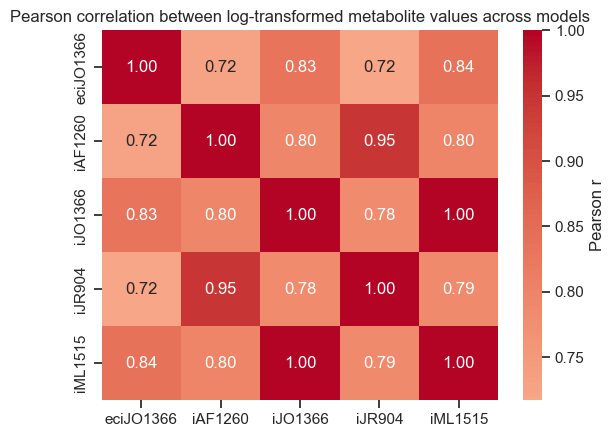

In [20]:
corr_matrix = corr_df.pivot(index='Model 1', columns='Model 2', values='Pearson r')
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0.5, cbar_kws={'label': 'Pearson r'})
plt.title('Pearson correlation between log-transformed metabolite values across models')
plt.ylabel('')
plt.xlabel('')

plt.savefig(git_folder / 'figures' / 'ecoli_models_metabolite_values_correlation_matrix.pdf', bbox_inches='tight')
plt.savefig(git_folder / 'figures' / 'ecoli_models_metabolite_values_correlation_matrix.png', bbox_inches='tight', dpi=300)


Text(0.01, 0.94, 'p=0.05')

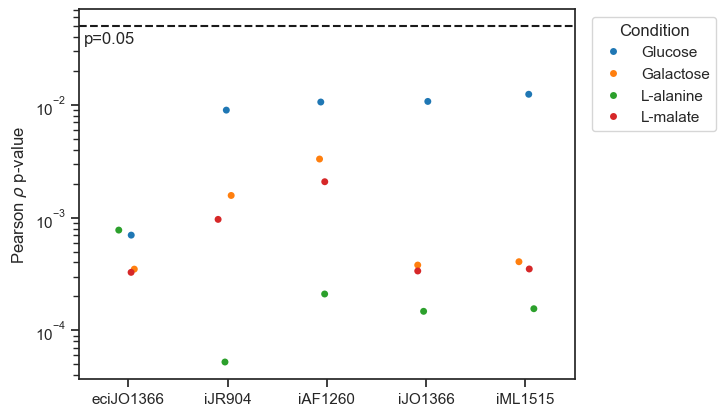

In [21]:
fit_df = pd.DataFrame(fit_data)
l = sns.stripplot(data=fit_df, x='Model', y='pearson_p', hue='Condition', palette='tab10', order=model_order)
sns.move_legend(l, 'upper right', bbox_to_anchor=(1.3, 1), title='Condition')
plt.yscale('log')
plt.ylabel(r'Pearson $\rho$ p-value')
plt.xlabel('')
plt.axhline(0.05, color='k', linestyle='--', label='p=0.05')
plt.annotate('p=0.05', xy=(0.01, 0.94), xycoords='axes fraction', ha='left', va='top', fontsize=12)

Text(0.01, 0.94, 'p=0.05')

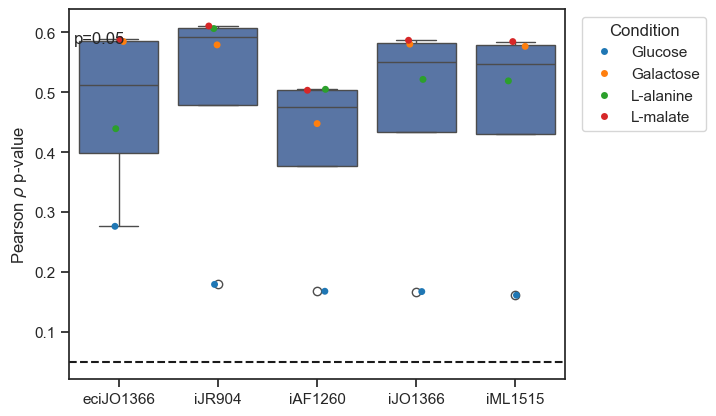

In [22]:
fit_df['rsquared'] = fit_df['rvalue'] ** 2
# l = sns.boxplot(data=fit_df, x='Model', y='rsquared', hue='Condition', palette='tab10', order=model_order)
l = sns.boxplot(data=fit_df, x='Model', y='rsquared', order=model_order)
sns.stripplot(data=fit_df, x='Model', y='rsquared', hue='Condition', palette='tab10', order=model_order, ax = l)
sns.move_legend(l, 'upper right', bbox_to_anchor=(1.3, 1), title='Condition')
# plt.yscale('log')
plt.ylabel(r'Pearson $\rho$ p-value')
plt.xlabel('')
plt.axhline(0.05, color='k', linestyle='--', label='p=0.05')
plt.annotate('p=0.05', xy=(0.01, 0.94), xycoords='axes fraction', ha='left', va='top', fontsize=12)

In [23]:
df_rates['log10(Rate [mmol/gDW/h])']

15    -3.490488
33    -3.490488
42    -0.690957
43    -0.211787
44     0.325205
         ...   
768   -1.881353
806   -5.649638
808         NaN
809   -4.215253
824   -4.191032
Name: log10(Rate [mmol/gDW/h]), Length: 133, dtype: float64

In [24]:
shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)},
                                                        metabolites = measured_metabolites)

NameError: name 'leakage_reframed' is not defined

In [ ]:
for (cs, species) in conditions:
    print(cs, species)
    model_fn = model_fns[species]
    model = reframed.load_cbmodel(model_fn)
    ex_id = cs_to_exchange[species][cs]
    
    break

Glucose E. coli
